In [2]:
# Import Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Concatenate, Input
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import json
import warnings
import os
from tqdm import tqdm
import concurrent.futures
import time
from pathlib import Path
import logging
from typing import List, Optional, Tuple

warnings.filterwarnings("ignore")
np.random.seed(42)

from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/chopin'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from music21 import converter
import os
from tqdm import tqdm

def parse_midi_file(file_path):
    try:
        return converter.parse(file_path)
    except Exception as e:
        print(f"Error loading '{file_path}': {e}")
        return None

def load_midi_files_parallel(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"The directory '{filepath}' does not exist.")

    midi_files = [os.path.join(filepath, f) for f in os.listdir(filepath) if f.endswith(".mid")]
    all_midis = []

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(parse_midi_file, midi_files), total=len(midi_files), desc="Loading MIDI files"))

    # Filter out None values for failed loads
    all_midis = [midi for midi in results if midi is not None]
    print(f"Total MIDI files successfully loaded: {len(all_midis)}")
    return all_midis

all_midis = load_midi_files_parallel(filepath)

Loading MIDI files: 100%|██████████| 48/48 [02:15<00:00,  2.82s/it]

Total MIDI files successfully loaded: 48


In [ ]:
def extract_notes_with_durations(file):
    notes_and_durations = []
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    # Store the actual pitch name instead of pitch class number
                    notes_and_durations.append((str(element.nameWithOctave), element.quarterLength))
                elif isinstance(element, chord.Chord):
                    # Store the actual pitch names for chord notes
                    chord_notes = ".".join(str(p.nameWithOctave) for p in element.pitches)
                    notes_and_durations.append((chord_notes, element.quarterLength))
    return notes_and_durations

# Usage:
Corpus_with_durations = extract_notes_with_durations(all_midis)
print("Total notes with durations:", len(Corpus_with_durations))

# Print a sample to verify the format
print("\nSample of extracted notes:")
print(Corpus_with_durations[:5])

Total notes with durations: 57894

Sample of extracted notes:
[('F2.C3', 0.25), ('C5', 0.25), ('A3', 2.0), ('F2.C3', 1.75), ('A4', 0.25)]


In [9]:
# Prepare Mappings
Corpus_notes = [note[0] for note in Corpus_with_durations]
Corpus_durations = [note[1] for note in Corpus_with_durations]

# Build mappings
notes_symb = sorted(list(set(Corpus_notes)))
durations_symb = sorted(list(set(Corpus_durations)))

notes_mapping = dict((c, i) for i, c in enumerate(notes_symb))
reverse_notes_mapping = dict((i, c) for i, c in enumerate(notes_symb))

durations_mapping = dict((c, i) for i, c in enumerate(durations_symb))
reverse_durations_mapping = dict((i, c) for i, c in enumerate(durations_symb))

print("Unique notes:", len(notes_mapping))
print("Unique durations:", len(durations_mapping))


NameError: name 'Corpus_with_durations' is not defined

In [ ]:
# Prepare Training Data
length = 40
note_features = []
duration_features = []
targets_notes = []
targets_durations = []

for i in range(0, len(Corpus_notes) - length, 1):
    note_features.append([notes_mapping[j] for j in Corpus_notes[i:i + length]])
    duration_features.append([durations_mapping[j] for j in Corpus_durations[i:i + length]])
    targets_notes.append(notes_mapping[Corpus_notes[i + length]])
    targets_durations.append(durations_mapping[Corpus_durations[i + length]])

note_features = np.reshape(note_features, (len(note_features), length, 1)) / float(len(notes_symb))
duration_features = np.reshape(duration_features, (len(duration_features), length, 1)) / float(len(durations_symb))
targets_notes = tensorflow.keras.utils.to_categorical(targets_notes)
targets_durations = tensorflow.keras.utils.to_categorical(targets_durations)

print("Number of sequences:", len(note_features))


Number of sequences: 57854


In [ ]:
# Define Model
note_input = Input(shape=(length, 1), name="note_input")
duration_input = Input(shape=(length, 1), name="duration_input")

# Notes LSTM
note_lstm = Bidirectional(LSTM(512, return_sequences=True))(note_input)
note_lstm = Dropout(0.1)(note_lstm)
note_lstm = Bidirectional(LSTM(256))(note_lstm)

# Durations LSTM
duration_lstm = Bidirectional(LSTM(512, return_sequences=True))(duration_input)
duration_lstm = Dropout(0.1)(duration_lstm)
duration_lstm = Bidirectional(LSTM(256))(duration_lstm)

# Concatenate outputs
combined = Concatenate()([note_lstm, duration_lstm])
dense = Dense(256, activation="relu")(combined)
dense = Dropout(0.1)(dense)

# Outputs
notes_output = Dense(len(notes_symb), activation="softmax", name="notes_output")(dense)
durations_output = Dense(len(durations_symb), activation="softmax", name="durations_output")(dense)

# Model
model = tensorflow.keras.Model(inputs=[note_input, duration_input], outputs=[notes_output, durations_output])

# Compile
opt = Adamax(learning_rate=0.01)
model.compile(
    loss=["categorical_crossentropy", "categorical_crossentropy"],  # One loss per output
    optimizer=opt,
    metrics=[["accuracy"], ["accuracy"]]  # One list of metrics per output
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ note_input (InputLayer)   │ (None, 40, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_input            │ (None, 40, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 40, 1024)       │      2,105,344 │ note_input[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 40, 1024)       │      2,105,344 │ duration_input[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 40, 1024)       │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 40, 1024)       │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 512)            │      2,623,488 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 512)            │      2,623,488 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1024)           │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        262,400 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ notes_output (Dense)      │ (None, 3372)           │        866,604 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ durations_output (Dense)  │ (None, 40)             │         10,280 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,596,948 (40.42 MB)

 Trainable params: 10,596,948 (40.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
history = model.fit(
    [note_features, duration_features],
    [targets_notes, targets_durations],
    batch_size=64,
    epochs=200,
    validation_split=0.1
)


Epoch 1/200
814/814 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - durations_output_accuracy: 0.4233 - durations_output_loss: 1.7193 - loss: 7.8569 - notes_output_accuracy: 0.0253 - notes_output_loss: 6.1376 - val_durations_output_accuracy: 0.4480 - val_durations_output_loss: 1.6241 - val_loss: 7.8176 - val_notes_output_accuracy: 0.0119 - val_notes_output_loss: 6.2178
Epoch 2/200
814/814 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - durations_output_accuracy: 0.4999 - durations_output_loss: 1.4593 - loss: 7.3502 - notes_output_accuracy: 0.0280 - notes_output_loss: 5.8909 - val_durations_output_accuracy: 0.4374 - val_durations_output_loss: 1.5376 - val_loss: 7.8530 - val_notes_output_accuracy: 0.0105 - val_notes_output_loss: 6.3411
Epoch 3/200
814/814 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - durations_output_accuracy: 0.5282 - durations_output_loss: 1.3930 - loss: 7.2432 - notes_output_accuracy: 0.0284 - notes_output_loss: 5.8502 - val_durations_output_accuracy: 0.3671 - val_durations_output_loss: 1.5483 - va

In [ ]:
# Save the Model and Mappings
model.save('/content/drive/MyDrive/music_generator.h5')

model_params = {
    'length': length,
    'notes_mapping': notes_mapping,
    'reverse_notes_mapping': reverse_notes_mapping,
    'durations_mapping': {str(k): v for k, v in durations_mapping.items()},
    'reverse_durations_mapping': {k: str(v) for k, v in reverse_durations_mapping.items()},
}


with open('/content/drive/MyDrive/model_param.json', 'w') as f:
    json.dump(model_params, f)


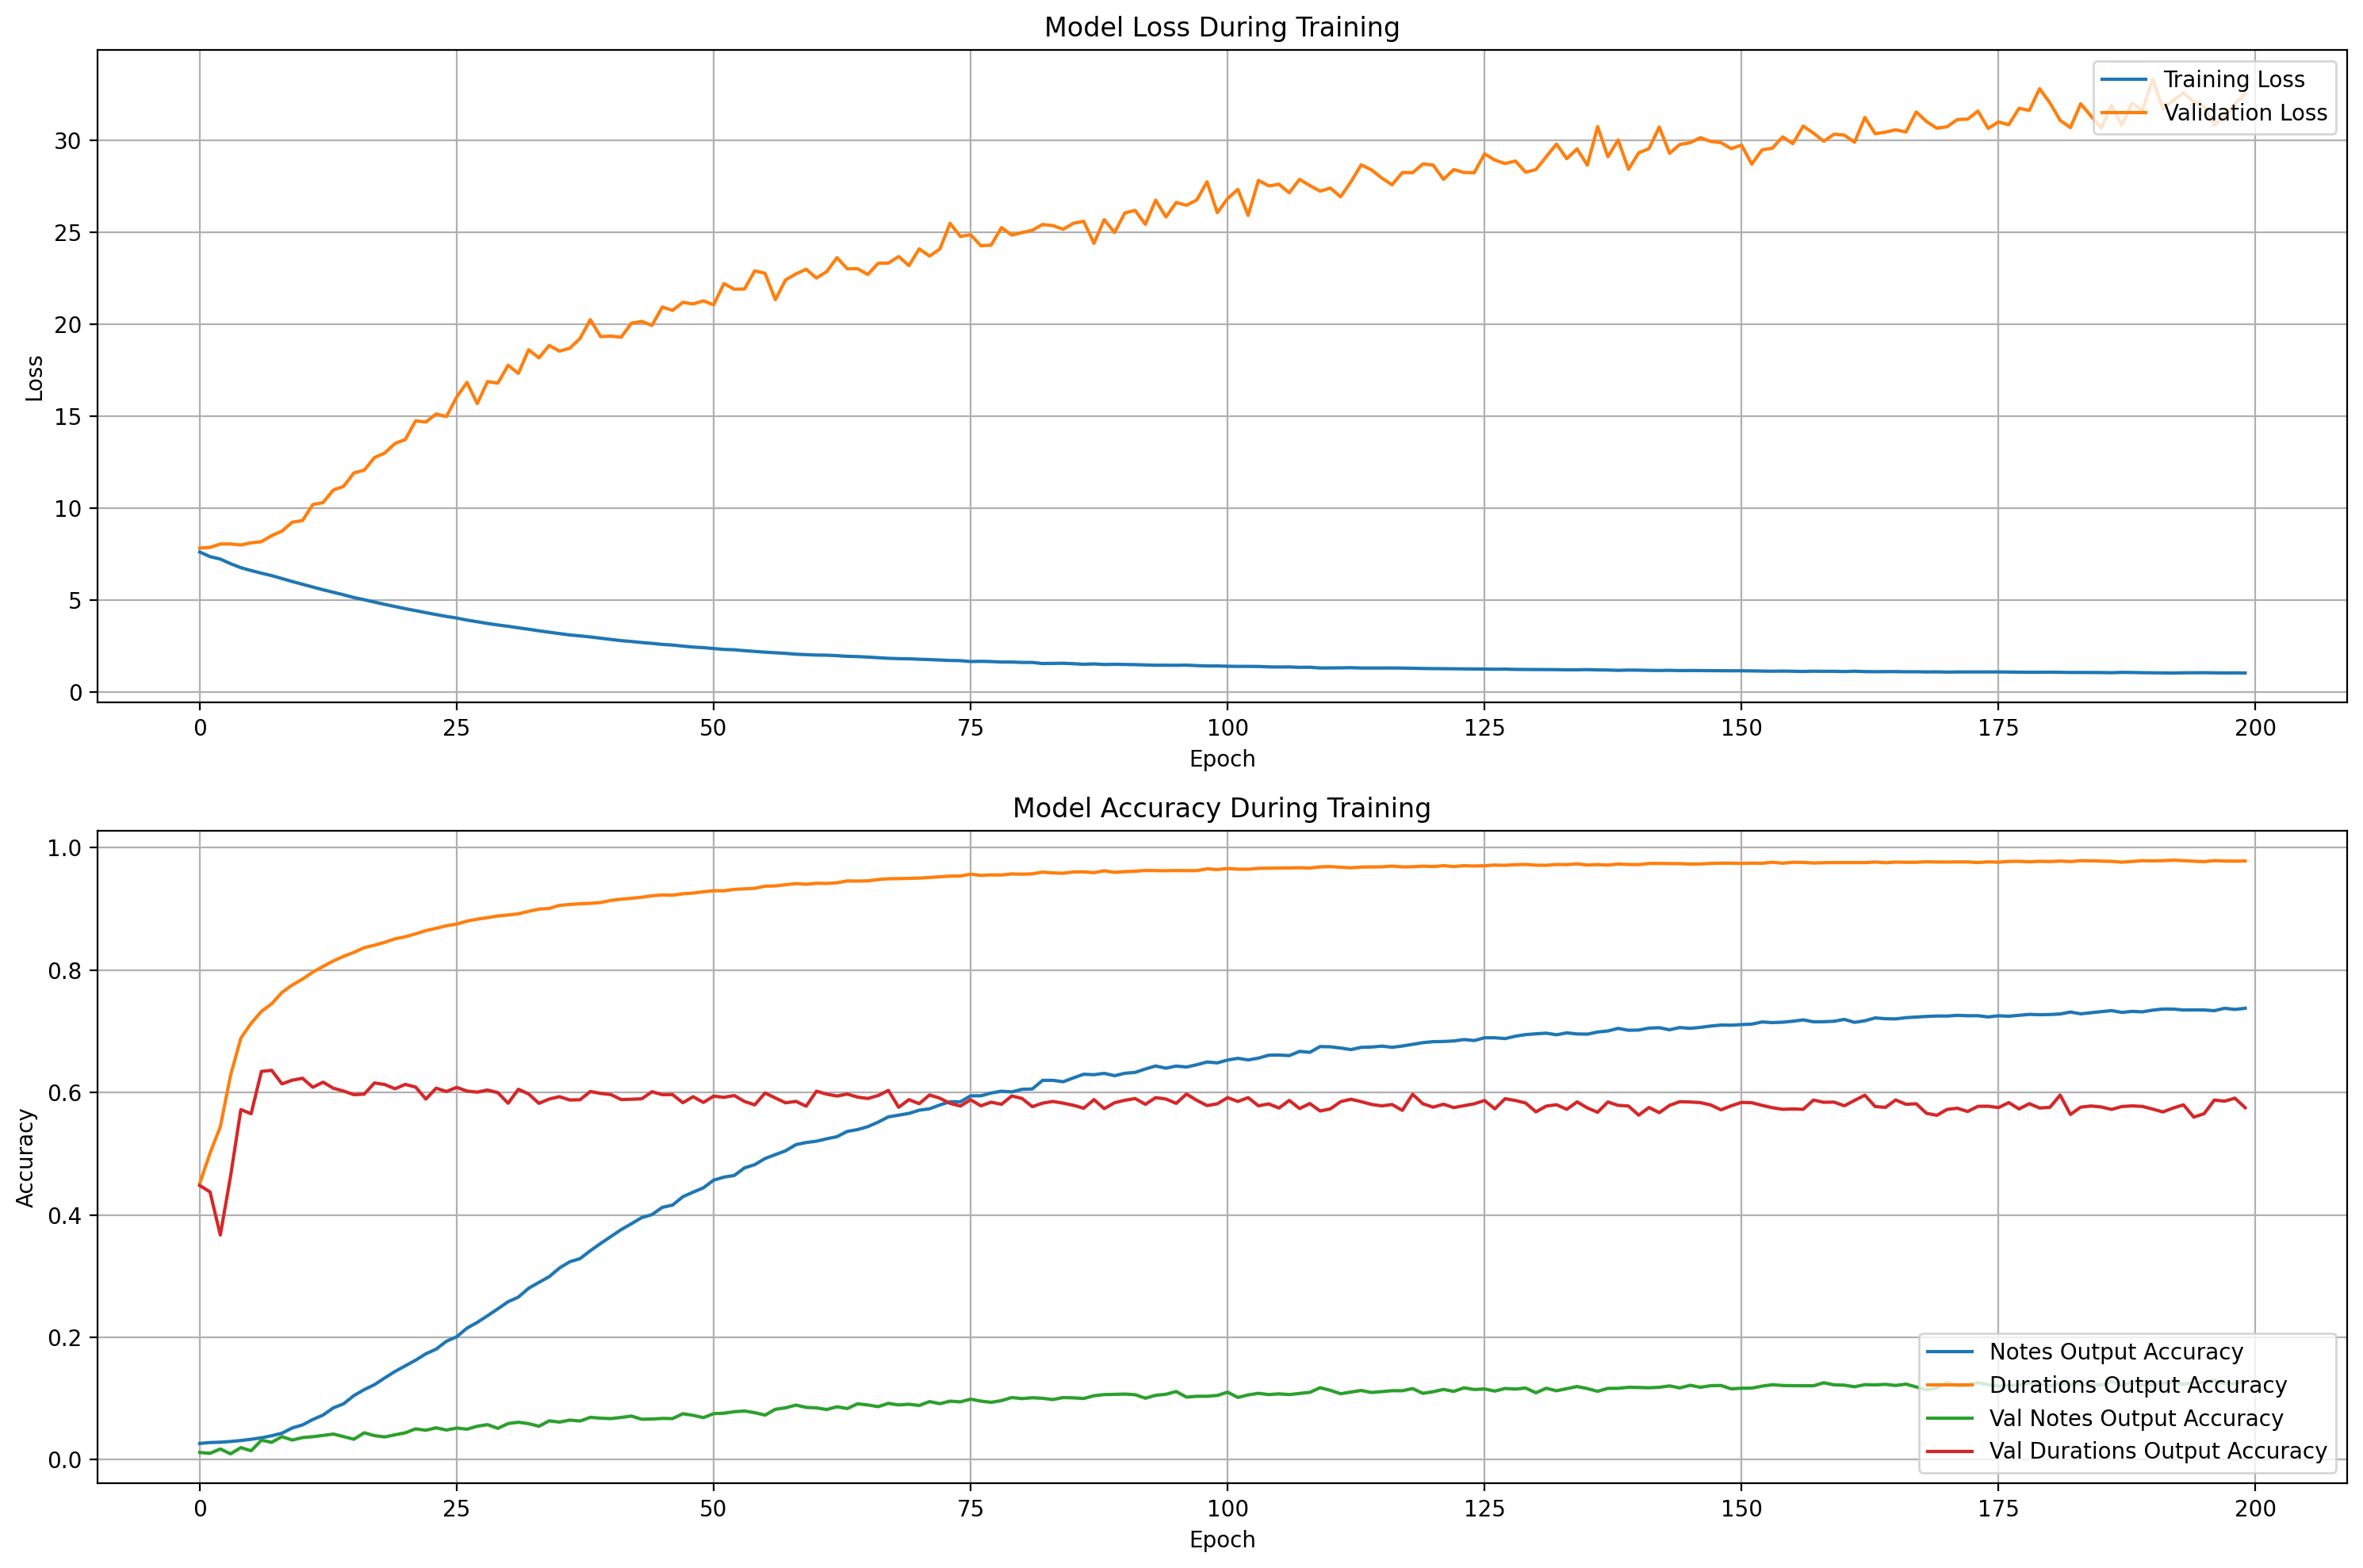

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_training_history(history):
    """
    Plot the training history including loss and accuracy metrics
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(2, 1, 2)
    metrics = ['notes_output_accuracy', 'durations_output_accuracy',
              'val_notes_output_accuracy', 'val_durations_output_accuracy']

    for metric in metrics:
        if metric in history.history:
            plt.plot(history.history[metric],
                    label=metric.replace('_', ' ').title())

    plt.title('Model Accuracy During Training')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    return fig

# To use this function:
fig = plot_training_history(history)
plt.show()

In [28]:
def Melody_Generator(Note_Count, temperature=0.5):
    """
    Generate melody using the loaded model
    """
    seed_notes = np.zeros((1, length, 1))
    seed_durations = np.zeros((1, length, 1))

    for i in range(length):
        seed_notes[0, i, 0] = np.random.randint(0, len(notes_mapping)) / float(len(notes_mapping))
        seed_durations[0, i, 0] = np.random.randint(0, len(durations_mapping)) / float(len(durations_mapping))

    notes_generated = []
    durations_generated = []

    for _ in range(Note_Count):
        predictions = model.predict([seed_notes, seed_durations], verbose=0)
        note_prediction = predictions[0][0]
        duration_prediction = predictions[1][0]

        note_prediction = np.log(note_prediction + 1e-10) / temperature
        duration_prediction = np.log(duration_prediction + 1e-10) / temperature

        exp_note_preds = np.exp(note_prediction)
        exp_duration_preds = np.exp(duration_prediction)

        note_prediction = exp_note_preds / np.sum(exp_note_preds)
        duration_prediction = exp_duration_preds / np.sum(exp_duration_preds)

        note_index = np.random.choice(len(note_prediction), p=note_prediction)
        duration_index = np.random.choice(len(duration_prediction), p=duration_prediction)

        # Check if the predicted indices exist in the mappings
        note_value = reverse_notes_mapping.get(note_index, "C4")  # Fallback to 'C4'
        duration_value = reverse_durations_mapping.get(duration_index, 0.5)  # Fallback to 0.5 sec

        if note_index not in reverse_notes_mapping or duration_index not in reverse_durations_mapping:
            print(f"Warning: Missing mapping for Note: {note_index}, Duration: {duration_index} (Using defaults: {note_value}, {duration_value})")

        notes_generated.append(note_value)
        durations_generated.append(duration_value)

        # Update seeds
        seed_notes = np.roll(seed_notes, -1, axis=1)
        seed_durations = np.roll(seed_durations, -1, axis=1)
        seed_notes[0, -1, 0] = note_index / float(len(notes_mapping))
        seed_durations[0, -1, 0] = duration_index / float(len(durations_mapping))

    return list(zip(notes_generated, durations_generated))

In [29]:
def create_midi_from_prediction(Music_notes, output_path):
    """
    Convert generated notes to MIDI file
    """
    generated_stream = stream.Stream()

    for n, d in Music_notes:
        if "." in n:  # It's a chord
            chord_notes = n.split(".")
            generated_chord = chord.Chord(chord_notes)
            generated_chord.quarterLength = float(d) if isinstance(d, str) else d
            generated_stream.append(generated_chord)
        else:  # It's a single note
            generated_note = note.Note(n)
            generated_note.quarterLength = float(d) if isinstance(d, str) else d
            generated_stream.append(generated_note)

    # Save as MIDI
    generated_stream.write('midi', fp=output_path)
    return generated_stream

In [30]:
# Test Melody Generator
Music_notes = Melody_Generator(100)
output_path = '/content/drive/MyDrive/generated_music.mid'
midi_stream = create_midi_from_prediction(Music_notes, output_path)
print("\nGenerated Music saved to:", output_path)


Generated Music saved to: /content/drive/MyDrive/generated_music.mid


In [27]:

from fractions import Fraction

# Load the trained model
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/music_generator.h5')

# Load the parameters
with open('/content/drive/MyDrive/model_param.json', 'r') as f:
    model_params = json.load(f)

# Restore the parameters
length = model_params['length']
reverse_notes_mapping = {int(k): v for k, v in model_params['reverse_notes_mapping'].items()}
reverse_durations_mapping = {int(k): float(Fraction(v)) for k, v in model_params['reverse_durations_mapping'].items()}



# Convert fraction strings to float values
durations_mapping = {}
for k, v in model_params['durations_mapping'].items():
    try:
        if '/' in k:
            # Handle fractions
            durations_mapping[float(Fraction(k))] = v
        else:
            # Handle regular numbers
            durations_mapping[float(k)] = v
    except ValueError as e:
        print(f"Warning: Could not convert duration '{k}': {e}")
        durations_mapping[k] = v  # Keep as string if conversion fails

# Similarly for reverse mapping
reverse_durations_mapping = {}
for k, v in model_params['reverse_durations_mapping'].items():
    try:
        key = int(k)
        if '/' in v:
            # Handle fractions
            value = float(Fraction(v))
        else:
            # Handle regular numbers
            value = float(v)
        reverse_durations_mapping[key] = value
    except ValueError as e:
        print(f"Warning: Could not convert duration '{v}': {e}")
        reverse_durations_mapping[int(k)] = v  # Keep as string if conversion fails

print("Sequence length:", length)
print("Number of unique notes:", len(notes_mapping))
print("Number of unique durations:", len(durations_mapping))

# Print some sample mappings to verify
print("\nSample note mappings:")
print(list(notes_mapping.items())[:3])
print("\nSample duration mappings:")
print(list(durations_mapping.items())[:3])

Sequence length: 40
Number of unique notes: 3372
Number of unique durations: 40

Sample note mappings:
[('A1', 0), ('A1.A2', 1), ('A1.B-1', 2)]

Sample duration mappings:
[(0.08333333333333333, 0), (0.16666666666666666, 1), (0.25, 2)]
